In [1]:
from pathlib import Path
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython.display import Video

import pandas as pd
import numpy as np
import torch

from lagom.envs import make_vec_env
from lagom.utils import pickle_load
from lagom.utils import yaml_load
from lagom.vis import set_ticker
from lagom.vis import read_xy

import os, sys
# solve import error of algos
[sys.path.insert(0, f'{os.getcwd()}/{f}') for f in ['vpg', 'ppo', 'ddpg']]


def get_configs(log_folder):
    data = pickle_load(Path(log_folder) / 'configs.pkl')
    configs = pd.DataFrame(data, columns=data[0].keys())
    return configs

/home/zuo/Code/tmp/lagom/lagom/vis/__init__.py:5: UserWarning: ImageViewer failed to import due to pyglet. 
  warnings.warn('ImageViewer failed to import due to pyglet. ')
/home/zuo/Code/tmp/lagom/lagom/envs/vec_env.py:12: UserWarning: ImageViewer failed to import due to pyglet. 
  warnings.warn('ImageViewer failed to import due to pyglet. ')


In [2]:
def make_video(id_folder, make_env, agent_class, seed, num_iter):
    id_folder = Path(id_folder)
    anim_path = id_folder / str(seed) / 'anim'
    if not anim_path.exists():
        anim_path.mkdir(parents=True)
    config = yaml_load(id_folder / 'config.yml')
    
    env = make_env(config, seed)
    import gym
    env[0] = gym.wrappers.Monitor(env[0], anim_path, force=True)
    
    def standardize(observation, mean, var):
        return (observation - mean)/np.sqrt(var + 1e-8)
    path_obs_moments = id_folder / str(seed) / f'obs_moments_{num_iter}.pth'
    if path_obs_moments.exists():
        obs_mean, obs_var = np.load(path_obs_moments)
    agent = agent_class(config, env, 'cpu')
    agent.load(id_folder / str(seed) / f'agent_{num_iter}.pth')
    agent.eval()
    
    rewards = 0.0
    observation = env.reset()
    with torch.no_grad():
        for t in range(env.spec.max_episode_steps):
            if path_obs_moments.exists():
                observation = standardize(observation, obs_mean, obs_var)
            out = agent.choose_action(observation, mode='eval')
            action = out.get('raw_action', out['action'])
            observation, reward, done, info = env.step(action)
            rewards += reward[0]
            if done[0]:
                break
    env.close()
    print(f'Evaluation:\n\tHorizon: {t+1}, Return: {rewards}')
    
    # display the video
    anim_f = list(anim_path.glob('*.mp4'))[0]
    return Video(anim_f)

# Reinforcement Learning
- [VPG](#VPG)
- [PPO](#PPO)
- [DDPG](#DDPG)
- [TD3](#TD3)
- [SAC](#SAC)
- [Benchmarking](#Benchmarking)

## VPG

In [3]:
log_folder = 'vpg/logs/default/'
get_configs(log_folder)

,ID,cuda,log.dir,log.freq,checkpoint.freq,env.standardize_obs,env.standardize_reward,env.time_aware_obs,nn.sizes,agent.lr,...,agent.entropy_coef,agent.value_coef,env.clip_action,agent.std0,agent.std_style,agent.std_range,agent.beta,train.timestep,train.timestep_per_iter,env.id
0,0,True,logs/default,10,50,True,True,False,"[64, 64]",0.001,...,0.01,0.5,True,0.5,exp,None,None,1000000,1000,HalfCheetah-v3
1,1,True,logs/default,10,50,True,True,False,"[64, 64]",0.001,...,0.01,0.5,True,0.5,exp,None,None,1000000,1000,Hopper-v3
2,2,True,logs/default,10,50,True,True,False,"[64, 64]",0.001,...,0.01,0.5,True,0.5,exp,None,None,1000000,1000,Walker2d-v3
3,3,True,logs/default,10,50,True,True,False,"[64, 64]",0.001,...,0.01,0.5,True,0.5,exp,None,None,1000000,1000,Swimmer-v3


In [4]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['running_return'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y)
data.head()

,x,y,ID,cuda,log.dir,log.freq,checkpoint.freq,env.standardize_obs,env.standardize_reward,env.time_aware_obs,...,agent.entropy_coef,agent.value_coef,env.clip_action,agent.std0,agent.std_style,agent.std_range,agent.beta,train.timestep,train.timestep_per_iter,env.id
0,1000,-10.730940,3.0,True,logs/default,10.0,50.0,True,True,False,...,0.01,0.5,True,0.5,exp,None,None,1000000.0,1000.0,Swimmer-v3
1,2000,5.786345,3.0,True,logs/default,10.0,50.0,True,True,False,...,0.01,0.5,True,0.5,exp,None,None,1000000.0,1000.0,Swimmer-v3
2,3000,7.821096,3.0,True,logs/default,10.0,50.0,True,True,False,...,0.01,0.5,True,0.5,exp,None,None,1000000.0,1000.0,Swimmer-v3
3,4000,4.284872,3.0,True,logs/default,10.0,50.0,True,True,False,...,0.01,0.5,True,0.5,exp,None,None,1000000.0,1000.0,Swimmer-v3
4,5000,5.646263,3.0,True,logs/default,10.0,50.0,True,True,False,...,0.01,0.5,True,0.5,exp,None,None,1000000.0,1000.0,Swimmer-v3


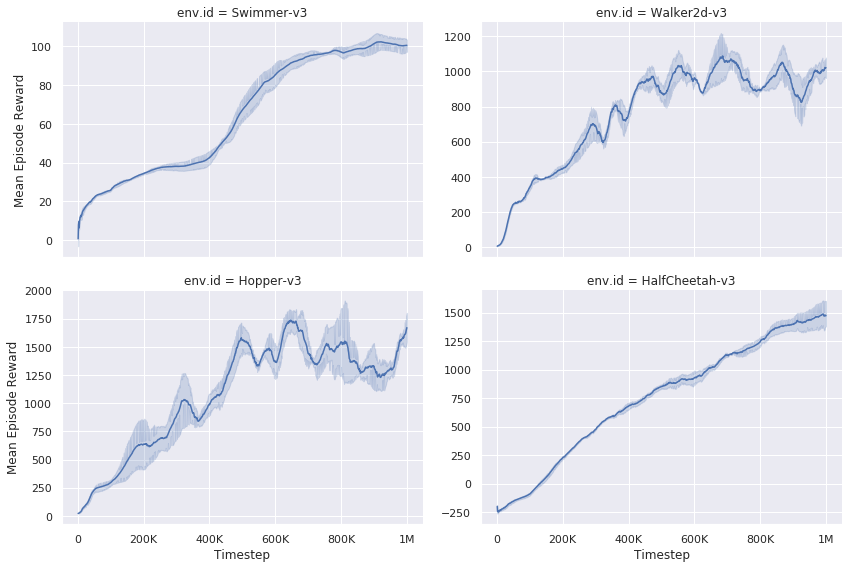

In [5]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [6]:
from vpg.agent import Agent
from vpg.experiment import make_env
ID = 3
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 107.95133498509509


## PPO

In [7]:
log_folder = 'ppo/logs/default/'
get_configs(log_folder)

,ID,cuda,log.dir,log.freq,checkpoint.freq,env.standardize_obs,env.standardize_reward,env.time_aware_obs,nn.sizes,agent.lr,...,env.clip_action,agent.std0,agent.std_style,agent.std_range,agent.beta,train.timestep,train.timestep_per_iter,train.batch_size,train.num_epochs,env.id
0,0,True,logs/default,10,50,True,True,False,"[64, 64]",0.001,...,True,0.5,exp,None,None,1000000,2000,256,80,HalfCheetah-v3
1,1,True,logs/default,10,50,True,True,False,"[64, 64]",0.001,...,True,0.5,exp,None,None,1000000,2000,256,80,Hopper-v3
2,2,True,logs/default,10,50,True,True,False,"[64, 64]",0.001,...,True,0.5,exp,None,None,1000000,2000,256,80,Walker2d-v3
3,3,True,logs/default,10,50,True,True,False,"[64, 64]",0.001,...,True,0.5,exp,None,None,1000000,2000,256,80,Swimmer-v3


In [8]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['running_return'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y)
data.head()

,x,y,ID,cuda,log.dir,log.freq,checkpoint.freq,env.standardize_obs,env.standardize_reward,env.time_aware_obs,...,env.clip_action,agent.std0,agent.std_style,agent.std_range,agent.beta,train.timestep,train.timestep_per_iter,train.batch_size,train.num_epochs,env.id
0,2000,1.123271,3.0,True,logs/default,10.0,50.0,True,True,False,...,True,0.5,exp,None,None,1000000.0,2000.0,256.0,80.0,Swimmer-v3
1,4000,-0.161098,3.0,True,logs/default,10.0,50.0,True,True,False,...,True,0.5,exp,None,None,1000000.0,2000.0,256.0,80.0,Swimmer-v3
2,6000,7.673534,3.0,True,logs/default,10.0,50.0,True,True,False,...,True,0.5,exp,None,None,1000000.0,2000.0,256.0,80.0,Swimmer-v3
3,8000,9.969522,3.0,True,logs/default,10.0,50.0,True,True,False,...,True,0.5,exp,None,None,1000000.0,2000.0,256.0,80.0,Swimmer-v3
4,10000,10.261435,3.0,True,logs/default,10.0,50.0,True,True,False,...,True,0.5,exp,None,None,1000000.0,2000.0,256.0,80.0,Swimmer-v3


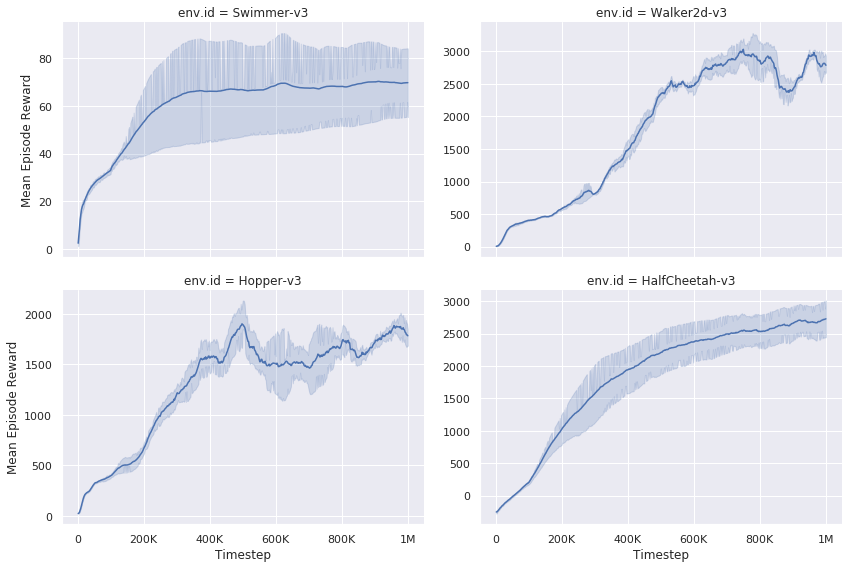

In [9]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [10]:
from ppo.agent import Agent
from ppo.experiment import make_env
ID = 0
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=500)

Evaluation:
	Horizon: 1000, Return: 3810.0863277895573


## DDPG

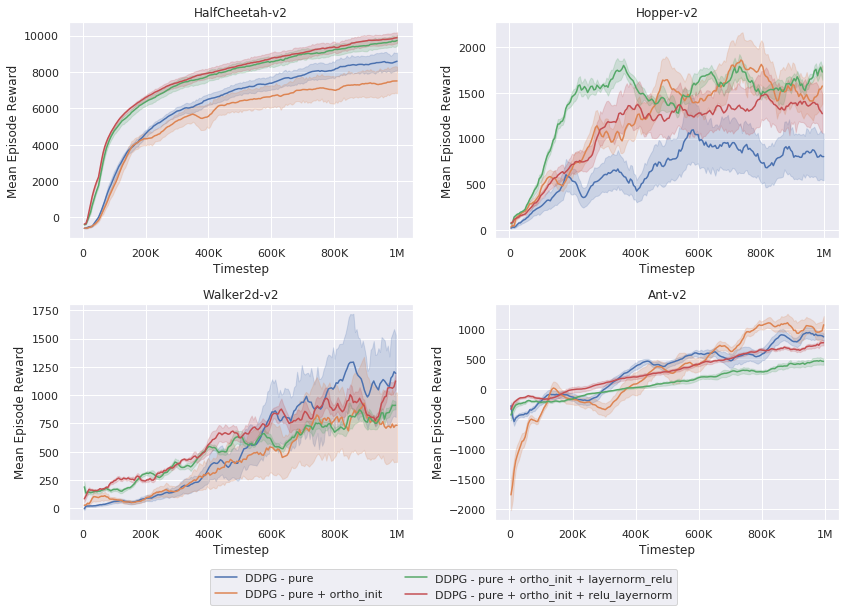

In [129]:
use eval_logs.pkl

## TD3

## SAC

## Benchmarking

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


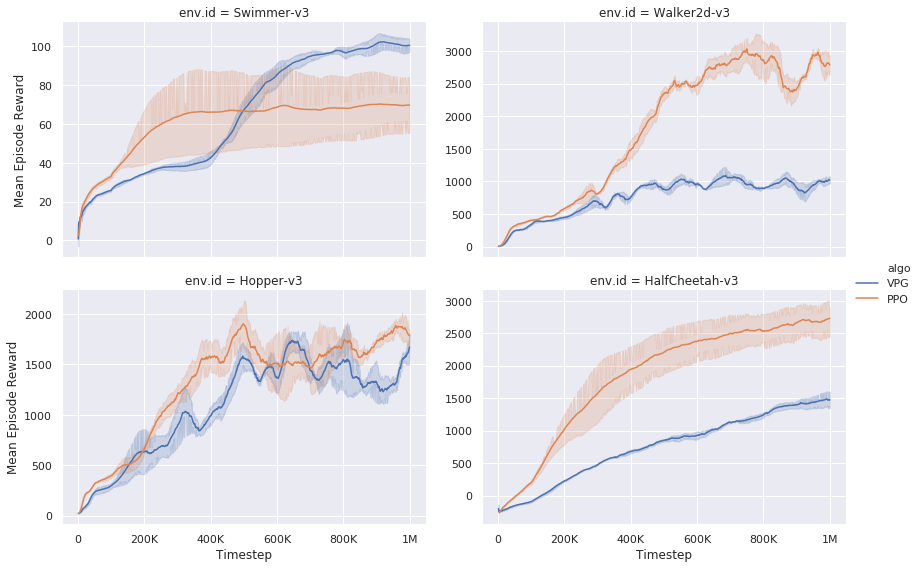

In [17]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['running_return'][0].mean
file_name = 'train_logs.pkl'

vpg_data = read_xy('vpg/logs/default', file_name, get_x, get_y)
vpg_data['algo'] = 'VPG'
ppo_data = read_xy('ppo/logs/default', file_name, get_x, get_y)
ppo_data['algo'] = 'PPO'

data = pd.concat([vpg_data, ppo_data], ignore_index=True, sort=False)

err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue='algo',
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'result.png')